In [6]:
!unzip "/content/ddos_veri_sade.zip" -d "/content/ddos_veri_sade"

Archive:  /content/ddos_veri_sade.zip
  inflating: /content/ddos_veri_sade/ddos_veri_sade.csv  


In [7]:
!pip install catboost xgboost seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [9]:
# CSV dosyasını oku (yolunu kendine göre güncelle)
df = pd.read_csv('/content/ddos_veri_sade/ddos_veri_sade.csv')

# 'label' sütununu 0-1'e çevir (binary classification)
df['label'] = df['label'].apply(lambda x: 0 if str(x).lower() == 'benign' else 1)

# İlk birkaç satırı kontrol et
df.head()

,syn_flag_number,syn_count,Header_Length,TCP,ack_flag_number,UDP,Protocol Type,Tot size,AVG,ack_count,...,Rate,Max,HTTPS,Time_To_Live,psh_flag_number,Min,Tot sum,rst_flag_number,IPv,label
0,0.153907,0.160389,0.977509,0.666349,1.276726,-0.646579,-0.605654,-0.317200,-0.317200,6.220507,...,-0.600588,0.032517,-0.503911,-0.352299,-0.300972,-0.117232,0.014097,11.977173,0.205161,0
1,-0.361245,-0.563636,0.769075,-0.012960,1.084734,-0.200365,-0.605654,-0.186878,-0.186878,0.249375,...,-0.785212,-0.053986,0.038993,0.018978,0.559992,-0.077512,-0.691070,-0.117375,0.205161,0
2,-0.595405,-0.586992,1.394377,0.455529,1.907556,-0.435214,-0.605654,1.690998,1.690998,0.543037,...,-0.787455,2.025949,1.753424,1.151586,4.386502,-0.077512,0.255423,-0.117375,0.205161,0
3,-0.595405,-0.586992,1.081726,0.221285,1.633282,-0.200365,-0.605654,-0.081752,-0.081752,0.445149,...,-0.779962,0.129833,-0.532485,0.121943,2.473247,-0.103992,-0.638084,-0.117375,0.205161,0
4,-0.595405,-0.586992,1.081726,0.221285,1.633282,-0.200365,-0.605654,0.478269,0.478269,0.445149,...,-0.778010,0.774744,1.753424,2.750562,0.559992,-0.077512,-0.355821,-0.117375,0.205161,0


In [10]:
selected_features = [
    'syn_flag_number', 'syn_count', 'UDP', 'TCP', 'Header_Length',
    'ack_flag_number', 'AVG', 'Tot size', 'Protocol Type', 'ack_count',
    'IAT', 'Rate', 'HTTPS', 'psh_flag_number', 'Time_To_Live',
    'Tot sum', 'rst_flag_number', 'Max', 'Min', 'IPv'
]

X = df[selected_features]
y = df['label']


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=selected_features)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "SVC": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}


In [13]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:32:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score
5,XGBoost,0.999788,0.999787,0.999788,0.999787
6,CatBoost,0.999762,0.999762,0.999762,0.999762
3,SVC,0.999675,0.999675,0.999675,0.999675
4,KNN,0.999513,0.999513,0.999513,0.999513
1,Decision Tree,0.999300,0.999300,0.999300,0.999300
0,Logistic Regression,0.998912,0.998913,0.998912,0.998912
2,Random Forest,0.998700,0.998704,0.998700,0.998701


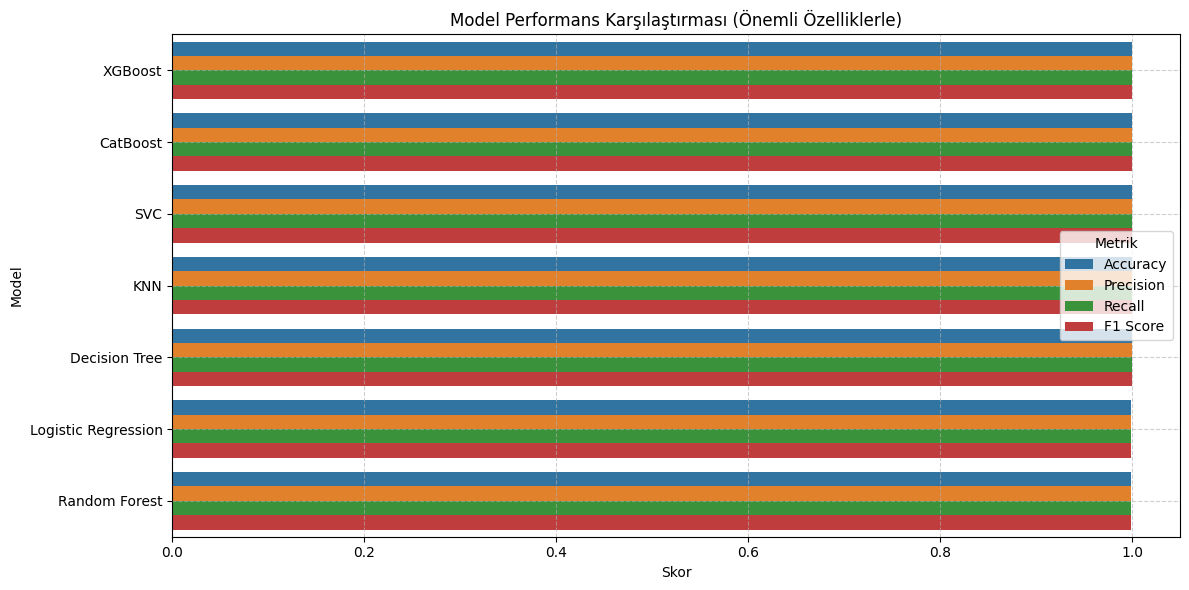

In [14]:
plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(x="Score", y="Model", hue="Metric", data=results_melted)
plt.title("Model Performans Karşılaştırması (Önemli Özelliklerle)")
plt.xlabel("Skor")
plt.ylabel("Model")
plt.legend(title="Metrik")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


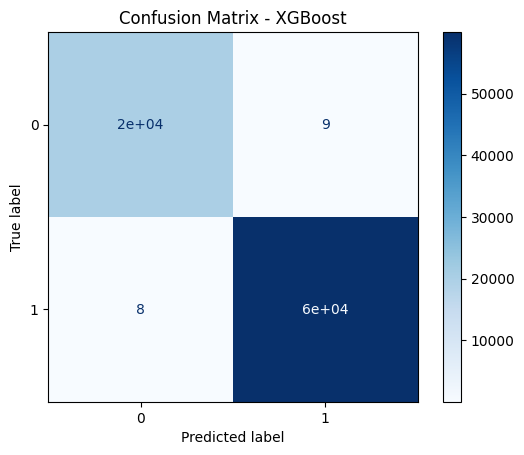

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# En yüksek F1 Score'a sahip modeli al
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

# Tahmin yap
y_pred_best = best_model.predict(X_test)

# Confusion matrix çiz
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.grid(False)
plt.show()


In [16]:
import joblib

# Modeli kaydet (örneğin: best_model.pkl)
joblib.dump(best_model, f'/content/{best_model_name.replace(" ", "_")}_model.pkl')


['/content/XGBoost_model.pkl']

In [28]:
# Modeli yükle
loaded_model = joblib.load(f'/content/{best_model_name.replace(" ", "_")}_model.pkl')

# Özellik adları
selected_features = [
    'syn_flag_number', 'syn_count', 'UDP', 'TCP', 'Header_Length',
    'ack_flag_number', 'AVG', 'Tot size', 'Protocol Type', 'ack_count',
    'IAT', 'Rate', 'HTTPS', 'psh_flag_number', 'Time_To_Live',
    'Tot sum', 'rst_flag_number', 'Max', 'Min', 'IPv'
]

sample_values = [[
    500,     # syn_flag_number: çok daha fazla SYN
    30000000,    # syn_count: çok daha yüksek SYN
    0,       # UDP
    1,       # TCP
    1200,     # Header_Length
    10,      # ack_flag_number: düşük ACK
    5000.0,  # AVG
    1000000, # Tot size: devasa toplam trafik
    6,       # Protocol Type
    5,       # ack_count: düşük
    0.001,   # IAT: çok sıkı (milisaniyeler)
    1000.0,  # Rate: anormal yüksek
    0,       # HTTPS yok
    0,       # psh_flag_number yok
    10,      # Time_To_Live: çok düşük (spoofing gibi)
    5000000, # Tot sum: devasa veri akışı
    0,       # rst_flag yok
    8000,    # Max
    10,      # Min
    4        # IPv4
]]


# DataFrame'e çevir
sample_df = pd.DataFrame(sample_values, columns=selected_features)

# StandardScaler uygulayıp tahmin et
sample_scaled = scaler.transform(sample_df)
predicted = loaded_model.predict(sample_scaled)[0]

print(f"Tahmin Edilen Sınıf (0: benign, 1: ddos): {predicted}")



Tahmin Edilen Sınıf (0: benign, 1: ddos): 0


In [18]:
y_loaded_pred = loaded_model.predict(X_test)
print(f"Yüklenen modelin test doğruluğu: {accuracy_score(y_test, y_loaded_pred):.4f}")


Yüklenen modelin test doğruluğu: 0.9998
